$\huge \textbf{Outlier detection}$

In this notebook, we will use different methods to detect points that display an anomalous behaviour. First I will show three unsupervised outlier detection using: Multivariate Gaussian model (3 sigma clipping and EllipticEnvelope), Local Outlier Factor, and the Isolation Forest methods.Second, I will show you two supervised methods: Support Vector Machine and Random Forest Classifier 

At the end we show a method comparison taken from: https://scikit-learn.org/0.20/auto_examples/plot_anomaly_comparison.html

$\Large \textbf{1.) Unsupervised Outlier Detection using Multivariate Gaussian Model}$

One common way of performing outlier detection is to assume that the regular data come from a known distribution (e.g. data are Gaussian distributed). From this assumption, we generally try to define the “shape” of the data (1,2,3 sigma confidence levels), and can define outlying observations as observations which stand far enough from the fit shape (3 sigma).

In [1]:
#Import package and figure properties
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal

plt.rcParams['legend.numpoints']=1
plt.rcParams['xtick.major.size'] = 11
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 11
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible']=True #See minor tick
plt.rcParams['text.usetex']=True #use Latex
plt.rcParams['axes.linewidth']=2 #width axes
plt.rcParams['axes.labelsize']=25 #
plt.rcParams['ytick.labelsize']=22 #fontsize of tick labels
plt.rcParams['xtick.labelsize']=22 #fontsize of tick labels
plt.rcParams['ytick.direction']='inout' ## direction: in, out, or inout
plt.rcParams['xtick.direction']='inout' ## direction: in, out, or inout

plt.rcParams['xtick.major.top']=True #draw x axis top major ticks
plt.rcParams['xtick.major.bottom']=True #draw x axis bottom major ticks
plt.rcParams['xtick.minor.top']=True ## draw x axis top minor ticks
plt.rcParams['xtick.minor.bottom']=True #draw x axis bottom minor ticks

plt.rcParams['ytick.major.left']=True #draw y axis left major ticks
plt.rcParams['ytick.major.right']=True #draw y axis right major ticks
plt.rcParams['ytick.minor.left']=True ## draw y axis left minor ticks
plt.rcParams['ytick.minor.right']=True #draw y axis right minor ticks


plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize']=22
plt.rcParams['figure.titlesize']=22

plt.rcParams['text.latex.preamble']=[r'\boldmath']

def check_model(TN,FP,FN,TP):
    #True Negative, False Positive, False Negative,rue Positive
    '''
    Accuracy: Accuracy is the most intuitive performance measure and it is simply a 
    ratio of correctly predicted observation to the total observations. 
    One may think that, if we have high accuracy then our model is best. 
    Yes, accuracy is a great measure but only when you have symmetric datasets 
    where values of false positive and false negatives are almost same. 
    Therefore, you have to look at other parameters to evaluate the performance of your model. 
    
    '''    
    accuracy=(TP+TN)/(TP+FN+FP+TN)
    
    '''
    Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive
    observations. The question that this metric answer is of all passengers that labeled as survived, 
    how many actually survived? High precision relates to the low false positive rate. 
    '''    
    precision = TP/(TP+FP)
    
    '''
    Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations
    in actual class - yes.
    '''
    recall= TP/(TP+FN)
    
    '''
    F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives 
    and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually 
    more useful than accuracy, especially if you have an uneven class distribution. 
    Accuracy works best if false positives and false negatives have similar cost. 
    If the cost of false positives and false negatives are very different, it’s better to look at both 
    Precision and Recall
    '''
    F1_score = 2*(recall * precision) / (recall + precision)
     
    print(f'Accuracy = {accuracy:.4f}')
    print(f'Precision = {precision:.4f}')
    print(f'Recall = {recall:.4f}')
    print(f'F1 score = {F1_score:.4f}')

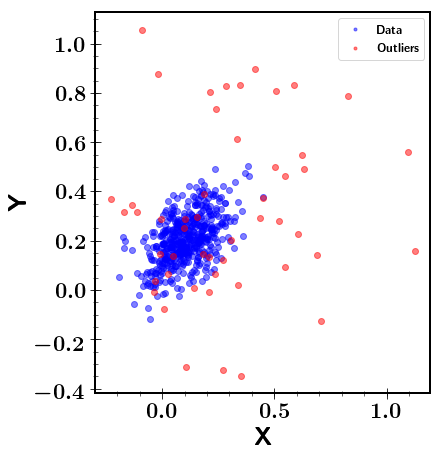

In [2]:
#Data
size=500
mean= np.array([0.1, 0.2])
cov = np.array([[0.01, 0.005], [0.005, 0.01]])

data= np.random.multivariate_normal(mean, cov, size=size)
X_data,Y_data=data[:, 0], data[:, 1]

# outliers
mean_out = np.array([0.15, 0.3])
cov_out = np.array([[0.1, 0], [0, 0.1]])

data_out = np.random.multivariate_normal(mean_out, cov_out, size=int(size/10)) # only 1/10 are outliers
X_out,Y_out=data_out[:,0],data_out[:,1]

#Figure
fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')

ax1.plot(X_data,Y_data,'bo',alpha=0.5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,label=r'\textbf{Outliers}')
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})

Almost the data are grouped together (blue) while a 50 data points are randomly displayed. To detect the outliers as we use the multivariate Gaussian method, we need to derive first the mean ($\mu$) and the standard deviation $\sigma$. Note the covariance matrix diagonal gives the n variances (squares of standard deviations) for the n variable.

In [3]:
#function to estimate parameters of a multivariate normal distribution based on the data
def estimate(X):
    """Calculates estimates of the means mu and variance sigma2 of the data X which contains several features."""
    mu = np.mean(X)
    sigma = np.std(X)
    return mu, sigma

#Regroup all the data
X_tot=np.concatenate((X_data,X_out))
Y_tot=np.concatenate((Y_data,Y_out))
points_tot=np.vstack((X_tot,Y_tot)).T

#We know
n_outliers = len(X_out)
target = np.ones(len(points_tot), dtype=int)
target[-n_outliers:] = -1

mu_X, sigma_X=estimate(X_tot)
mu_Y,sigma_Y =estimate(Y_tot)
print("The mean of X", mu_X)
print("The standard deviation of X", sigma_X)
print("The mean of Y", mu_Y)
print("The standard deviation of Y", sigma_Y)

The mean of X 0.123092383306
The standard deviation of X 0.141360950851
The mean of Y 0.217232737906
The standard deviation of Y 0.14247157344



Now let's define and plot the 1,2,3 sigma contours (60,95,99.7) of the data (including outliers)

In [4]:
def plot_cov_ellipse(points, nstd=2, ax=None, **kwargs):
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height =  2* nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellip)
    return ellip



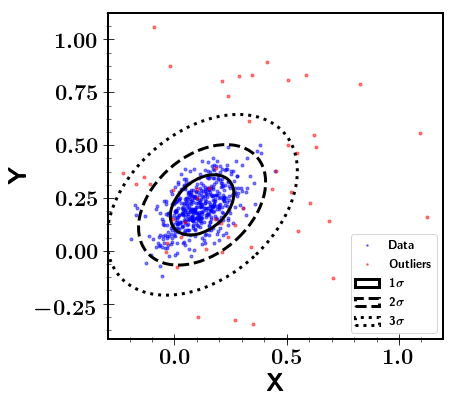

In [5]:
from matplotlib.patches import Ellipse
#Figure
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=3,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=3,label=r'\textbf{Outliers}')

plot_cov_ellipse(points_tot, nstd=1, ax=ax1,edgecolor='k', fc='None', lw=3,zorder=3,label=r'\textbf{1$\sigma$}')
plot_cov_ellipse(points_tot, nstd=2, ax=ax1,edgecolor='k',linestyle='--', fc='None', lw=3,zorder=3,label=r'\textbf{2$\sigma$}')
plot_cov_ellipse(points_tot, nstd=3, ax=ax1,edgecolor='k', linestyle=':',fc='None', lw=3,zorder=3,label=r'\textbf{3$\sigma$}')

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=1,prop={'size':12})

In Astronomy, we generally use a 3-sigma cut to remove the outliers. Therefore all the point situated outside the 3-sigma ellipse are considered as outliers

In [6]:
def point_out_ellipse(points, nstd=3):
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    theta=-theta*np.pi/180
    # Width and height are "full" widths, not radius
    width, height = nstd * np.sqrt(vals)
    
    value=(((points[:,0]-pos[0])*np.cos(theta)+(points[:,1]-pos[1])*np.sin(theta))/height)**2+(((points[:,0]-pos[0])*np.sin(theta)-(points[:,1]-pos[1])*np.cos(theta))/width)**2
    return points[value>1]

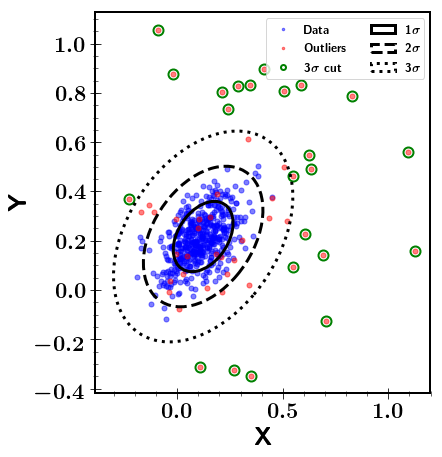

In [7]:
nstd=3

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')

plot_cov_ellipse(points_tot, nstd=1, ax=ax1,edgecolor='k', fc='None', lw=3,zorder=3,label=r'\textbf{1$\sigma$}')
plot_cov_ellipse(points_tot, nstd=2, ax=ax1,edgecolor='k',linestyle='--', fc='None', lw=3,zorder=3,label=r'\textbf{2$\sigma$}')
plot_cov_ellipse(points_tot, nstd=3, ax=ax1,edgecolor='k', linestyle=':',fc='None', lw=3,zorder=3,label=r'\textbf{3$\sigma$}')

ax1.plot(point_out_ellipse(points_tot,nstd).T[0],point_out_ellipse(points_tot,nstd).T[1],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=10,linestyle='None',label=r'\textbf{%s$\sigma$ cut}'%nstd)

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=2,prop={'size':12})

In [8]:
from sklearn.metrics import *

x = (point_out_ellipse(points_tot,nstd)[:, None] == data_out).all(-1)
tot_removed=np.shape(point_out_ellipse(points_tot,nstd))[0]
print('###### Multivariate Gaussian Model ######')
print(r"Number of outliers well removed %s/%s with %s-sigma cut"%(np.size(x[x==True]),np.size(X_out),nstd))
print(r"Number of data removed %s/%s with %s-sigma cut"%(tot_removed-np.size(x[x==True]),np.size(X_data),nstd))

print('######Classification metric for Multivariate Gaussian Model: ##########')
check_model(np.size(x[x==True]),np.size(X_out)-np.size(x[x==True]),(tot_removed-np.size(x[x==True])),np.size(X_data)-(tot_removed-np.size(x[x==True])))#TN FP FN TP

###### Multivariate Gaussian Model ######
Number of outliers well removed 23/50 with 3-sigma cut
Number of data removed 0/500 with 3-sigma cut
######Classification metric for Multivariate Gaussian Model: ##########
Accuracy = 0.9509
Precision = 0.9488
Recall = 1.0000
F1 score = 0.9737


Using a 3-sigma cut, we remove the majority of the outlier

$\Large \textbf{2.) Unsupervised Outlier Detection using EllipticEnvelope (Elli)}$:

EllipticEnvelope which can also be unsupervised, fits the tightest Gaussianthat it can while discarding some fixed fraction of contamination points set by the user. This method is better than the previous used as it allows us to include the amount of contamination of the data. Therefore, the Gaussian distribution will be more similar to the real data (more elliptical than previously).

The threshold for being an outlier is 0


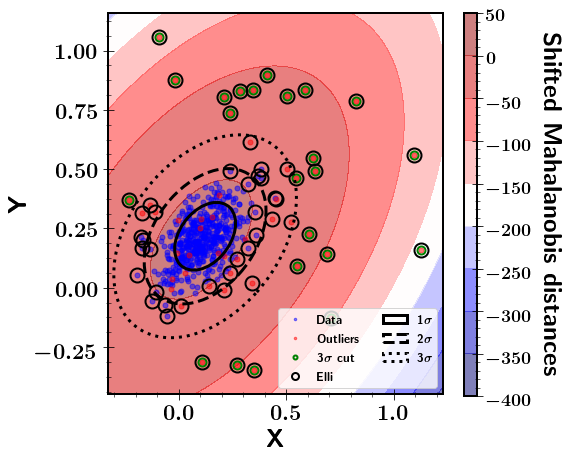

In [9]:
from sklearn.covariance import EllipticEnvelope
import scipy.stats as stats

outlier_frac = 0.10 #10% of outliers
elli = EllipticEnvelope(contamination=outlier_frac)
elli.fit(points_tot)
y_pred_elli = elli.predict(points_tot)

xx, yy = np.meshgrid(np.linspace(np.min(points_tot[:,0])-0.1, np.max(points_tot[:,0])+0.1, 200), np.linspace(np.min(points_tot[:,1])-0.1, np.max(points_tot[:,1])+0.1, 200))
Z = elli.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
threshold = stats.scoreatpercentile(elli.decision_function(points_tot), 100*outlier_frac)
print(r"The threshold for being an outlier is %s"%int(threshold))

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')
cont=ax1.contourf(xx, yy, Z,alpha=0.5,cmap=plt.cm.seismic) 
cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cont,cax=cax)
clb.ax.set_ylabel(r'\textbf{Shifted Mahalanobis distances}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)

plot_cov_ellipse(points_tot, nstd=1, ax=ax1,edgecolor='k', fc='None', lw=3,zorder=3,label=r'\textbf{1$\sigma$}')
plot_cov_ellipse(points_tot, nstd=2, ax=ax1,edgecolor='k',linestyle='--', fc='None', lw=3,zorder=3,label=r'\textbf{2$\sigma$}')
plot_cov_ellipse(points_tot, nstd=3, ax=ax1,edgecolor='k', linestyle=':',fc='None', lw=3,zorder=3,label=r'\textbf{3$\sigma$}')

ax1.plot(point_out_ellipse(points_tot,nstd).T[0],point_out_ellipse(points_tot,nstd).T[1],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=8,linestyle='None',label=r'\textbf{%s$\sigma$ cut}'%nstd)
ax1.plot(points_tot[:,0][y_pred_elli==-1],points_tot[:,1][y_pred_elli==-1],color='k',marker='o',markerfacecolor='None',markeredgecolor='black',mew=2,markersize=14,linestyle='None',label=r'\textbf{Elli}')
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=2,prop={'size':12})

In [10]:
x_elli = np.size(y_pred_elli[-50:][y_pred_elli[-50:]==-1])
tot_rem_elli=np.size(y_pred_elli[y_pred_elli==-1])
print('####### EllipticEnvelope #######')
print(r"Number of outliers well removed %s/%s with EllipticEnvelope"%(x_elli,np.size(X_out)))
print(r"Number of data  removed %s/%s with EllipticEnvelope"%(tot_rem_elli-x_elli,np.size(X_data)))

print('######Classification metric for EllipticEnvelope: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_elli):.4f}')
print(f'Precision = {precision_score(target, y_pred_elli):.4f}')
print(f'Recall = {recall_score(target, y_pred_elli):.4f}')
print(f'F1 score = {f1_score(target, y_pred_elli):.4f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_elli)*100:.2f}')

####### EllipticEnvelope #######
Number of outliers well removed 37/50 with EllipticEnvelope
Number of data  removed 18/500 with EllipticEnvelope
######Classification metric for EllipticEnvelope: ##########
Accuracy = 0.9436
Precision = 0.9737
Recall = 0.9640
F1 score = 0.9688
ROC AUC score = 85.20


$\Large \textbf{3.) Unsupervised Outlier Detection using Local Outlier Factor (LOF)}$:

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

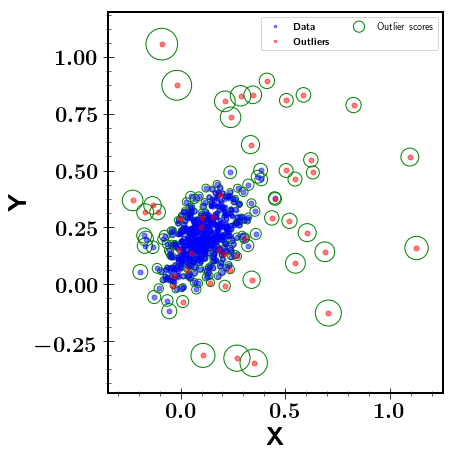

In [11]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model for outlier detection (default)
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred_lof = lof.fit_predict(points_tot)

X_scores_lof = lof.negative_outlier_factor_
radius = (X_scores_lof.max() - X_scores_lof) / (X_scores_lof.max() - X_scores_lof.min())
fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')

#plot_cov_ellipse(points_tot, nstd=1, ax=ax1,edgecolor='k', fc='None', lw=3,zorder=3,label=r'\textbf{1$\sigma$}')
#plot_cov_ellipse(points_tot, nstd=2, ax=ax1,edgecolor='k',linestyle='--', fc='None', lw=3,zorder=3,label=r'\textbf{2$\sigma$}')
#plot_cov_ellipse(points_tot, nstd=3, ax=ax1,edgecolor='k', linestyle=':',fc='None', lw=3,zorder=3,label=r'\textbf{3$\sigma$}')
ax1.scatter(points_tot[:, 0], points_tot[:, 1], s=1000 * radius, edgecolors='g',facecolors='none', label='Outlier scores')
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=2,prop={'size':10})

In [12]:
#Let's put a cut in the score: mean score+ 1sigma
Outlier_LOF=points_tot[radius>np.mean(radius)+np.std(radius)]

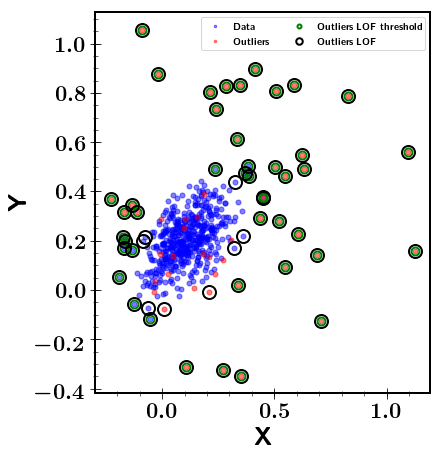

In [13]:
fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')
ax1.plot(Outlier_LOF[:,0], Outlier_LOF[:,1],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=8,linestyle='None',label=r'\textbf{Outliers LOF threshold}')

ax1.plot(points_tot[:,0][y_pred_lof==-1], points_tot[:,1][y_pred_lof==-1],color='k',marker='o',markerfacecolor='None',markeredgecolor='black',mew=2,markersize=13,linestyle='None',label=r'\textbf{Outliers LOF}')


#plot_cov_ellipse(points_tot, nstd=1, ax=ax1,edgecolor='k', fc='None', lw=3,zorder=3,label=r'\textbf{1$\sigma$}')
#plot_cov_ellipse(points_tot, nstd=2, ax=ax1,edgecolor='k',linestyle='--', fc='None', lw=3,zorder=3,label=r'\textbf{2$\sigma$}')
#plot_cov_ellipse(points_tot, nstd=3, ax=ax1,edgecolor='k', linestyle=':',fc='None', lw=3,zorder=3,label=r'\textbf{3$\sigma$}')
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=2,prop={'size':10})

In [14]:
x_lof_1sig = (Outlier_LOF[:, None] == data_out).all(-1)
tot_rem_lof_1sig=np.shape(Outlier_LOF[:, None])[0]

print('####### LOF and threshold of 1 sigma #######')
print(r"Number of outliers well removed %s/%s with 1-sigma cut"%(np.size(x_lof_1sig[x_lof_1sig==True]),np.size(X_out)))
print(r"Number of data  removed %s/%s with 1-sigma cut"%(tot_rem_lof_1sig-np.size(x_lof_1sig[x_lof_1sig==True]),np.size(X_data)))
print('######Classification metric for LOF and threshold: ##########')
check_model(np.size(x_lof_1sig[x_lof_1sig==True]),np.size(X_out)-np.size(x_lof_1sig[x_lof_1sig==True]),tot_rem_lof_1sig-np.size(x_lof_1sig[x_lof_1sig==True]),np.size(X_data)-(tot_rem_lof_1sig-np.size(x_lof_1sig[x_lof_1sig==True])))#TN FP FN TP
x_lof = np.size(y_pred_lof[-50:][y_pred_lof[-50:]==-1])
tot_rem_lof=np.size(y_pred_lof[y_pred_lof==-1])
print('####### LOF #######')
print(r"Number of outliers well removed %s/%s with LOF"%(x_lof,np.size(X_out)))
print(r"Number of data  removed %s/%s with LOF"%(tot_rem_lof-x_lof,np.size(X_data)))

print('######Classification metric for LOF: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_lof):.4f}')
print(f'Precision = {precision_score(target, y_pred_lof):.4f}')
print(f'Recall = {recall_score(target, y_pred_lof):.4f}')
print(f'F1 score = {f1_score(target, y_pred_lof):.4f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_lof)*100:.2f}')



####### LOF and threshold of 1 sigma #######
Number of outliers well removed 32/50 with 1-sigma cut
Number of data  removed 12/500 with 1-sigma cut
######Classification metric for LOF and threshold: ##########
Accuracy = 0.9455
Precision = 0.9644
Recall = 0.9760
F1 score = 0.9702
####### LOF #######
Number of outliers well removed 34/50 with LOF
Number of data  removed 18/500 with LOF
######Classification metric for LOF: ##########
Accuracy = 0.9382
Precision = 0.9679
Recall = 0.9640
F1 score = 0.9659
ROC AUC score = 82.20


$\Large \textbf{4.) Unsupervised Outlier Detection using Isolation Forest (IF)}$:

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

Text(0,0.5,'\\textbf{Y}')

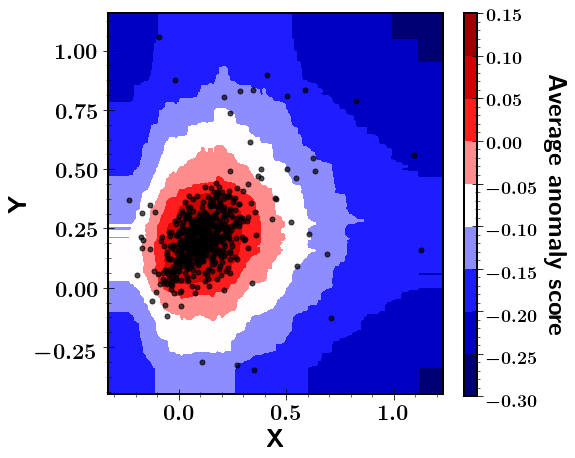

In [15]:
from sklearn.ensemble import IsolationForest

# Isolation Forests
# contamination: percentage of outliers
clf = IsolationForest(max_samples=200, behaviour='new',contamination='auto')
clf.fit(points_tot)
y_pred_if = clf.fit_predict(points_tot)


# plot decision boundries 
fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
#create grid of points
xx, yy = np.meshgrid(np.linspace(np.min(points_tot[:,0])-0.1, np.max(points_tot[:,0])+0.1, 200), np.linspace(np.min(points_tot[:,1])-0.1, np.max(points_tot[:,1])+0.1, 200))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cont=ax1.contourf(xx, yy, Z,7,cmap=plt.cm.seismic) #note for contour values: cont.allsegs

#Color bar
cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cont,cax=cax)
clb.ax.set_ylabel(r'\textbf{Average anomaly score}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)


# plot the acutal objects
ax1.plot(points_tot[:, 0], points_tot[:, 1], color='k',marker='o',alpha=0.7,ms=5,linestyle='None')

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')


By eye, we can define a threshold below which an object will be defined as an outlier. Here I select: -0.05, it means that all the data in the darkblue,blue, gray will be considered as outliers while the data in the pink, red, and darkred will be considered as the data.

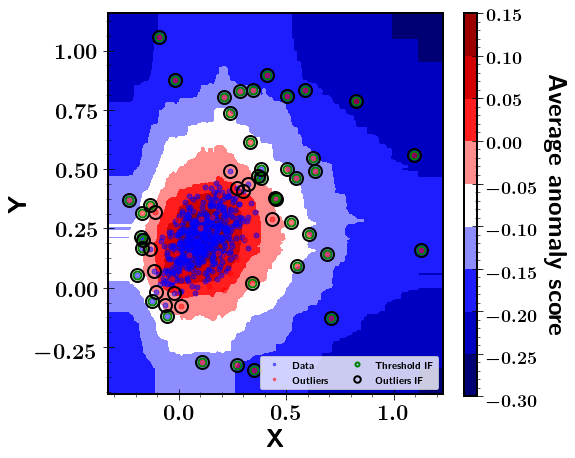

In [16]:
threshold=-0.05

from scipy.interpolate import griddata

pt = np.array( (xx.flatten(), yy.flatten()) ).T
val = Z.flatten()

# We will sample the grid at the point location
Z0 = griddata( pt, val, (points_tot[:,0],points_tot[:,1]))
#To see if a point has a value <0.05,
outlier_IF=points_tot[Z0<threshold]

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')

ax1.plot(outlier_IF[:,0], outlier_IF[:,1],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=8,linestyle='None',label=r'\textbf{Threshold IF}')
cont=ax1.contourf(xx, yy, Z,7,cmap=plt.cm.seismic) #note for contour values: cont.allsegs

ax1.plot(points_tot[:,0][y_pred_if==-1], points_tot[:,1][y_pred_if==-1],color='k',marker='o',markerfacecolor='None',markeredgecolor='black',mew=2,markersize=13,linestyle='None',label=r'\textbf{Outliers IF}')


#Color bar
cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cont,cax=cax)
clb.ax.set_ylabel(r'\textbf{Average anomaly score}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=4,title='',markerscale=0.5,ncol=2,prop={'size':10})

In [17]:
x_out_real = (outlier_IF[:, None] == data_out).all(-1)
#bad remove= total removed- good removed
n_bad_rem=np.shape(outlier_IF[:,0])[0]-np.size(x_out_real[x_out_real==True])

print('####### IF and threshold of 1 sigma #######')
print(r"Number of outliers well removed %s/%s with threshold"%(np.size(x_out_real[x_out_real==True]),np.size(X_out)))
print(r"Number of data  removed %s/%s with 1-sigma threshold"%(n_bad_rem,np.size(X_data)))
print('######Classification metric for IF+ Threshold: ##########')
check_model(np.size(x_out_real[x_out_real==True]),np.size(X_out)-np.size(x_out_real[x_out_real==True]),n_bad_rem,np.size(X_data)-n_bad_rem)#TN FP FN TP

x_if = np.size(y_pred_if[-50:][y_pred_if[-50:]==-1])
tot_rem_if=np.size(y_pred_if[y_pred_if==-1])

print('####### IF #######')
print(r"Number of outliers well removed %s/%s with IF"%(x_if,np.size(X_out)))
print(r"Number of data  removed %s/%s with IF"%(tot_rem_if-x_if,np.size(X_data)))

print('######Classification metric for IF: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_if):.2f}')
print(f'Precision = {precision_score(target, y_pred_if):.2f}')
print(f'Recall = {recall_score(target, y_pred_if):.2f}')
print(f'F1 score = {f1_score(target, y_pred_if):.2f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_if)*100:.2f}')

####### IF and threshold of 1 sigma #######
Number of outliers well removed 30/50 with threshold
Number of data  removed 10/500 with 1-sigma threshold
######Classification metric for IF+ Threshold: ##########
Accuracy = 0.9455
Precision = 0.9608
Recall = 0.9800
F1 score = 0.9703
####### IF #######
Number of outliers well removed 33/50 with IF
Number of data  removed 19/500 with IF
######Classification metric for IF: ##########
Accuracy = 0.93
Precision = 0.97
Recall = 0.96
F1 score = 0.96
ROC AUC score = 81.10


$\Large \textbf{5.) Supervised Outlier Detection using Support Vector Machine (SVM)}$:

SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes.

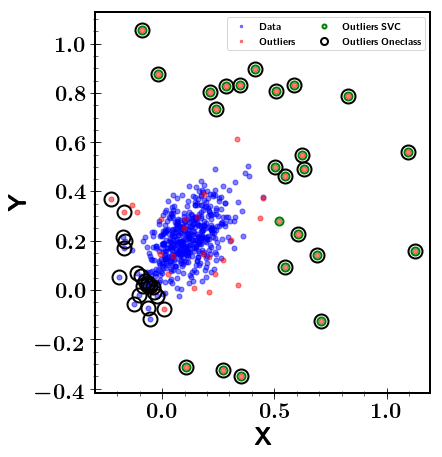

In [18]:
from sklearn import svm
import pandas as pd 
# data+outliers = points_tot
# Because it is a supervised machine learning, we need labels: target= 1 for data, -1 for outliers
#put data in a dataframe
df = pd.DataFrame(points_tot, columns=['X', 'Y'])
df['class'] = target
#filters for data based on Y
real = df['class'] == 1
false = df['class'] == -1
# Let's split the data in random train and test subsets
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(df[['X', 'Y']], df['class'], test_size = 0.3, random_state = 0)

# train a one-class SVM. Start with some hyper parameters
#clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.01)
#Training of SVM with RBF (radial basis function) kernel
#SVC
svc=svm.SVC(C=100, kernel='rbf',gamma='auto', probability=True)
svc.fit(xTrain,yTrain)

#OneclassSVM
oneClass=svm.OneClassSVM(nu=0.07, kernel='rbf',gamma='auto')
oneClass.fit(xTrain,yTrain)

# now we can predict for all the objects whether they belong to the class (1) or not (-1).
y_pred_train_svc = svc.predict(xTrain)
y_pred_test_svc = svc.predict(xTest)
y_pred_tot_svc=svc.predict(points_tot)

y_pred_train_oneClass = oneClass.predict(xTrain)
y_pred_test_oneClass = oneClass.predict(xTest)
y_pred_tot_oneClass=oneClass.predict(points_tot)

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(df['X'][real],df['Y'][real],'bo',alpha=0.5,ms=5,label=r'\textbf{Data}',zorder=1)
ax1.plot(df['X'][false], df['Y'][false],'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}',zorder=1)

ax1.plot(df['X'][y_pred_tot_svc==-1], df['Y'][y_pred_tot_svc==-1],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=8,linestyle='None',label=r'\textbf{Outliers SVC}',zorder=1)

ax1.plot(df['X'][y_pred_tot_oneClass==-1], df['Y'][y_pred_tot_oneClass==-1],color='k',marker='o',markerfacecolor='None',markeredgecolor='black',mew=2,markersize=14,linestyle='None',label=r'\textbf{Outliers Oneclass}',zorder=2)


ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=0,title='',markerscale=0.5,ncol=2,prop={'size':10})

In [19]:
n_out_rem=np.size(y_pred_tot_svc[-50:][y_pred_tot_svc[-50:]==-1])
n_tot_out=np.size(y_pred_tot_svc[y_pred_tot_svc==-1])
print('##### SVC #####')
print(r"Using SVM and SVC we remove %s/%s of the outliers "%(n_out_rem,np.size(X_out)))
print(r"Using SVM and SVC we remove %s/%s of the real data"%((n_tot_out-n_out_rem),np.size(X_data)))

print('######Classification metric for SVC: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_tot_svc):.2f}')
print(f'Precision = {precision_score(target, y_pred_tot_svc):.2f}')
print(f'Recall = {recall_score(target, y_pred_tot_svc):.2f}')
print(f'F1 score = {f1_score(target, y_pred_tot_svc):.2f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_tot_svc)*100:.2f}')


n_out_rem_oneclass=np.size(y_pred_tot_oneClass[-50:][y_pred_tot_oneClass[-50:]==-1])
n_tot_out_oneclass=np.size(y_pred_tot_oneClass[y_pred_tot_oneClass==-1])

print('##### OneclassSVM #####')
print(r"Using SVM and Oneclass we remove %s/%s of the outliers "%(n_out_rem_oneclass,np.size(X_out)))
print(r"Using SVM and Oneclass we remove %s/%s of the real data"%((n_tot_out_oneclass-n_out_rem_oneclass),np.size(X_data)))

print('######Classification metric for OneclassSVM: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_tot_oneClass):.2f}')
print(f'Precision = {precision_score(target, y_pred_tot_oneClass):.2f}')
print(f'Recall = {recall_score(target, y_pred_tot_oneClass):.2f}')
print(f'F1 score = {f1_score(target, y_pred_tot_oneClass):.2f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_tot_oneClass)*100:.2f}')




##### SVC #####
Using SVM and SVC we remove 24/50 of the outliers 
Using SVM and SVC we remove 0/500 of the real data
######Classification metric for SVC: ##########
Accuracy = 0.95
Precision = 0.95
Recall = 1.00
F1 score = 0.97
ROC AUC score = 74.00
##### OneclassSVM #####
Using SVM and Oneclass we remove 27/50 of the outliers 
Using SVM and Oneclass we remove 17/500 of the real data
######Classification metric for OneclassSVM: ##########
Accuracy = 0.93
Precision = 0.95
Recall = 0.97
F1 score = 0.96
ROC AUC score = 75.30


Text(0,0.5,'\\textbf{Y}')

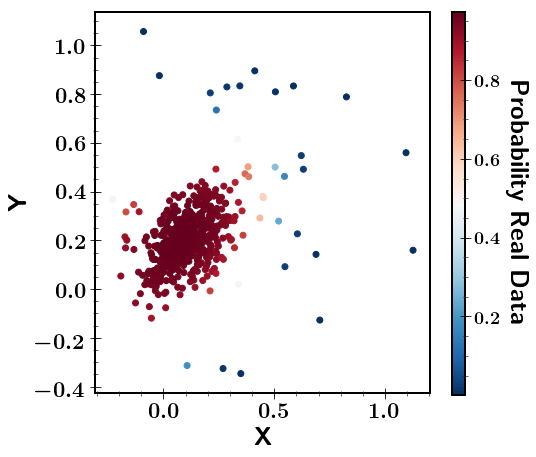

In [20]:
# If you want to plot the probability to be real data using SVC:
fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')

cs = ax1.scatter(df['X'], df['Y'], c=svc.predict_proba(points_tot)[:,1], cmap='RdBu_r')

cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cs,cax=cax)
clb.ax.set_ylabel(r'\textbf{Probability Real Data}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')


$\Large \textbf{6.) Supervised Outlier Detection using Random Forest Classifier (RF)}$:

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [21]:
from sklearn.ensemble import RandomForestClassifier
# train a supervised RF to separate between the two groups
# number of trees: 50
XTrain, XTest, yTrain, yTest = train_test_split(df[['X', 'Y']], df['class'], test_size = 0.2, random_state = 0)
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(XTrain, yTrain)
# let's examine the prediction of the RF on the training and the test set
y_train_pred = rfc.predict(XTrain)
y_test_pred = rfc.predict(XTest)

# get the classification accuracy on the training and the test set
score_train = rfc.score(XTrain, yTrain)
score_test = rfc.score(XTest, yTest)
print ('accuracy on training set: ', score_train)
print ('accuracy on test set: ', score_test)

accuracy on training set:  1.0
accuracy on test set:  0.963636363636


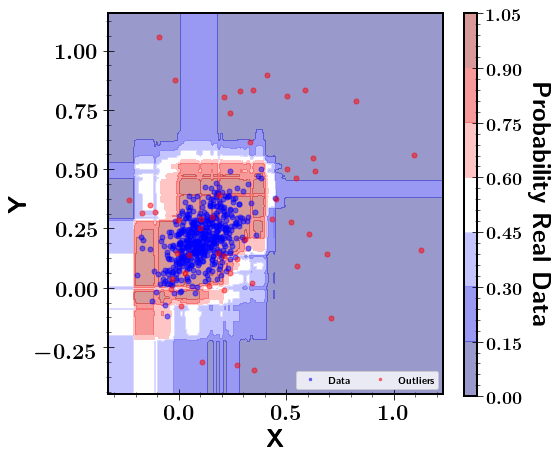

In [22]:
# first create the decision boundries of the RF - this corresponds to the probability of the prediction
Z_rfc = rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_rfc = Z_rfc.reshape(xx.shape)

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}')
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}')

cont=ax1.contourf(xx, yy, Z_rfc,7,alpha=0.4,cmap=plt.cm.seismic) #note for contour values: cont.allsegs

#Color bar
cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cont,cax=cax)
clb.ax.set_ylabel(r'\textbf{Probability Real Data}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)

ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=4,title='',markerscale=0.5,ncol=2,prop={'size':10})

Two ways: we define the outliers as having a probability <0.50 or we look at the predictions

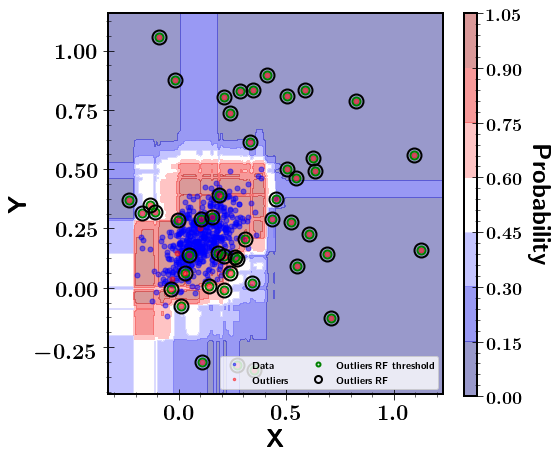

In [23]:
proba_threshold = 0.50
y_proba_train_rfc = rfc.predict_proba(XTrain)[:,1]
y_proba_test_rfc = rfc.predict_proba(XTest)[:,1]
y_proba_tot_rfc=rfc.predict_proba(points_tot)[:,1]

Outlier_rfc=df[y_proba_tot_rfc<=proba_threshold]

y_pred_train_rfc = rfc.predict(XTrain)
y_pred_test_rfc = rfc.predict(XTest)
y_pred_tot_rfc=rfc.predict(points_tot)

Z_rfc = rfc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_rfc = Z_rfc.reshape(xx.shape)

fig,ax1 = plt.subplots(figsize=(6,7), facecolor='w', edgecolor='k')
ax1.plot(X_data,Y_data,'bo',alpha=0.5,ms=5,label=r'\textbf{Data}',zorder=2)
ax1.plot(X_out, Y_out,'ro',alpha=0.5,ms=5,label=r'\textbf{Outliers}',zorder=2)
ax1.plot(Outlier_rfc['X'], Outlier_rfc['Y'],color='g',marker='o',markerfacecolor='None',markeredgecolor='green',mew=2,markersize=8,linestyle='None',label=r'\textbf{Outliers RF threshold}',zorder=3)
ax1.plot(df['X'][y_pred_tot_rfc==-1], df['Y'][y_pred_tot_rfc==-1],color='k',marker='o',markerfacecolor='None',markeredgecolor='black',mew=2,markersize=14,linestyle='None',label=r'\textbf{Outliers RF}',zorder=3)
cont=ax1.contourf(xx, yy, Z_rfc,7,alpha=0.4,cmap=plt.cm.seismic) #note for contour values: cont.allsegs
#Color bar
cax = plt.axes([0.95, 0.120, 0.03, 0.76])
clb = plt.colorbar(cont,cax=cax)
clb.ax.set_ylabel(r'\textbf{Probability}', labelpad=30, rotation=270,fontsize=plt.rcParams['axes.labelsize'])
clb.ax.tick_params(labelsize=18)
ax1.set_xlabel(r'\textbf{X}')
ax1.set_ylabel(r'\textbf{Y}')
ax1.legend(loc=4,title='',markerscale=0.5,ncol=2,prop={'size':10})

In [24]:
n_out_rem=np.size(y_pred_tot_rfc[-50:][y_pred_tot_rfc[-50:]==-1])
n_tot_out=np.size(y_pred_tot_rfc[y_pred_tot_rfc==-1])
print('##### Random Forect Classifier  #####')

print(r"Using RF we remove %s/%s of the outliers "%(n_out_rem,np.size(X_out)))
print(r"Using RF we remove %s/%s of the real data"%((n_tot_out-n_out_rem),np.size(X_data)))

print('######Classification metric for RF: ##########')

print(f'Accuracy = {accuracy_score(target, y_pred_tot_rfc):.4f}')
print(f'Precision = {precision_score(target, y_pred_tot_rfc):.4f}')
print(f'Recall = {recall_score(target, y_pred_tot_rfc):.4f}')
print(f'F1 score = {f1_score(target, y_pred_tot_rfc):.4f}')
print(f'ROC AUC score = {roc_auc_score(target, y_pred_tot_rfc)*100:.4f}')


n_out_rem=np.shape(pd.merge(Outlier_rfc, df[df['class']==-1], how='inner'))[0]
n_tot_out=np.size(y_proba_tot_rfc[y_proba_tot_rfc<=proba_threshold])
print('##### RF + threshold #####')
print(r"Using RF+threshold we remove %s/%s of the outliers "%(n_out_rem,np.size(X_out)))
print(r"Using RF+threshold we remove %s/%s of the real data"%((n_tot_out-n_out_rem),np.size(X_data)))
print('###### Classification metric for RF+threshold: ##########')
check_model(n_out_rem,np.size(X_out)-n_out_rem,(n_tot_out-n_out_rem),np.size(X_data)-(n_tot_out-n_out_rem))#TN FP FN TP

##### Random Forect Classifier  #####
Using RF we remove 47/50 of the outliers 
Using RF we remove 1/500 of the real data
######Classification metric for RF: ##########
Accuracy = 0.9927
Precision = 0.9940
Recall = 0.9980
F1 score = 0.9960
ROC AUC score = 96.9000
##### RF + threshold #####
Using RF+threshold we remove 47/50 of the outliers 
Using RF+threshold we remove 1/500 of the real data
###### Classification metric for RF+threshold: ##########
Accuracy = 0.9927
Precision = 0.9940
Recall = 0.9980
F1 score = 0.9960


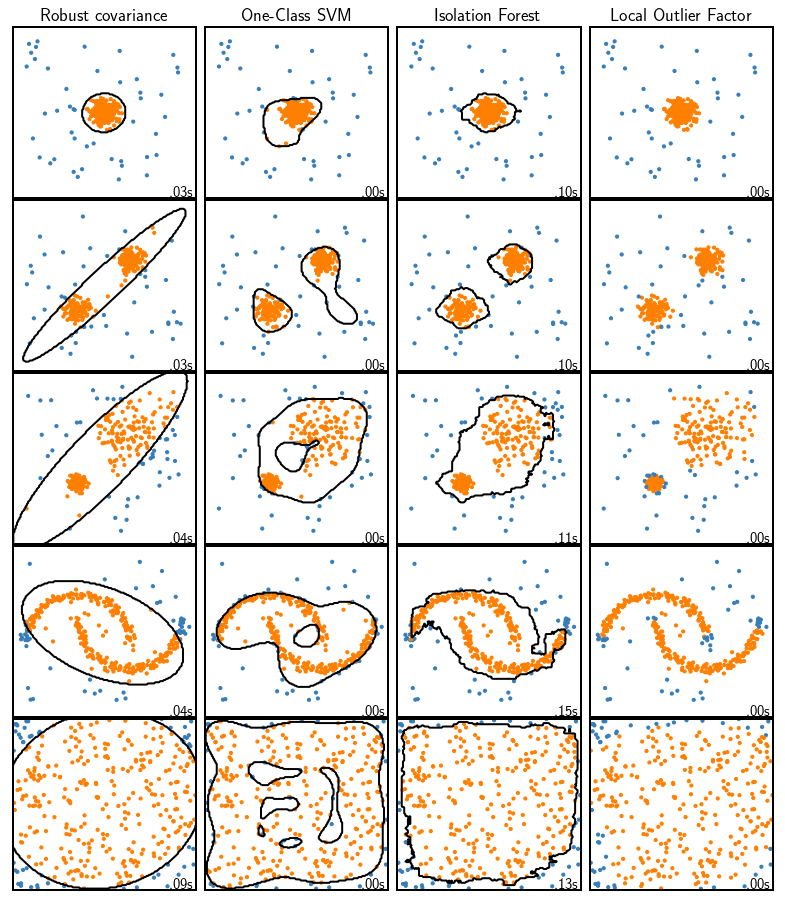

In [26]:
from sklearn.datasets import make_moons, make_blobs
import time
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1